In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import random 


In [42]:
# Load historical stock price data
import yfinance as yf
ticker_symbol = "MSFT"  # Google ticker symbol
start_date = "2010-11-01"
end_date = "2020-12-31"

# Fetch historical stock data
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date, interval="1wk")
stock = list(stock_data['Close'])
df = pd.DataFrame(columns=range(0,31))
for i in range(len(stock) - 30):
    row_data = stock[i:i+31]  # Extract i to i+5 elements
    df.loc[i] = row_data
df.shape

[*********************100%%**********************]  1 of 1 completed


(501, 31)

In [43]:
df

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,26.850000,26.270000,25.690001,25.250000,27.020000,27.340000,27.900000,28.299999,27.910000,28.600000,...,25.480000,26.070000,25.370001,25.520000,25.920000,25.870001,25.030001,24.490000,24.760000,23.910000
1,26.270000,25.690001,25.250000,27.020000,27.340000,27.900000,28.299999,27.910000,28.600000,28.299999,...,26.070000,25.370001,25.520000,25.920000,25.870001,25.030001,24.490000,24.760000,23.910000,23.709999
2,25.690001,25.250000,27.020000,27.340000,27.900000,28.299999,27.910000,28.600000,28.299999,28.020000,...,25.370001,25.520000,25.920000,25.870001,25.030001,24.490000,24.760000,23.910000,23.709999,24.260000
3,25.250000,27.020000,27.340000,27.900000,28.299999,27.910000,28.600000,28.299999,28.020000,27.750000,...,25.520000,25.920000,25.870001,25.030001,24.490000,24.760000,23.910000,23.709999,24.260000,24.299999
4,27.020000,27.340000,27.900000,28.299999,27.910000,28.600000,28.299999,28.020000,27.750000,27.770000,...,25.920000,25.870001,25.030001,24.490000,24.760000,23.910000,23.709999,24.260000,24.299999,26.020000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,184.679993,183.160004,183.509995,183.250000,187.199997,187.740005,195.149994,196.330002,206.259995,213.669998,...,206.190002,215.809998,219.660004,216.229996,202.470001,223.720001,216.509995,210.389999,215.229996,214.360001
497,183.160004,183.509995,183.250000,187.199997,187.740005,195.149994,196.330002,206.259995,213.669998,202.880005,...,215.809998,219.660004,216.229996,202.470001,223.720001,216.509995,210.389999,215.229996,214.360001,213.259995
498,183.509995,183.250000,187.199997,187.740005,195.149994,196.330002,206.259995,213.669998,202.880005,201.300003,...,219.660004,216.229996,202.470001,223.720001,216.509995,210.389999,215.229996,214.360001,213.259995,218.589996
499,183.250000,187.199997,187.740005,195.149994,196.330002,206.259995,213.669998,202.880005,201.300003,205.009995,...,216.229996,202.470001,223.720001,216.509995,210.389999,215.229996,214.360001,213.259995,218.589996,222.750000


In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.iloc[:,:-1]
Y = df.iloc[:,-1]
X_train_1,X_test_1, Y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [19]:
def models(X_train_1,X_test_1):
    error = {}
    small = 999999
    for i in range(1,4):
        X_train = X_train_1.iloc[:,26-i*3:-4]
        X_test = X_test_1.iloc[:,26-i*3:-4]

        scale = StandardScaler()
        X_train = scale.fit_transform(X_train)
        X_test = scale.transform(X_test)

        for j in range(8,12):
            # Define the model
            model = Sequential()
            model.add(LSTM(units=10*j, return_sequences=True, input_shape=(X_train.shape[1], 1)))
            model.add(LSTM(units=10*j))
            model.add(Dense(1))

            for k in range(6,10):

                # Compile the model
                model.compile(optimizer='adam', loss='mean_squared_error')
                model.fit(X_train, Y_train, epochs=k*10, batch_size=64)
                # Make predictions on the test set
                y_pred = model.predict(X_test)

                # Evaluate the model
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)
                s = str(26-i*3)+', '+str(10*j)+', '+str(k*10)
                error[s]=rmse
                
                if rmse<small:
                    small = rmse
                    ss = s
                    m = model
                    e = rmse
                    sc = scale
                    
        return m,e,sc,ss

In [20]:
model2, error2, scale2, which = models(X_train_1, X_test_1)

Epoch 1/60
7/7 [==============================] - 10s 14ms/step - loss: 7832.0195
Epoch 2/60
7/7 [==============================] - 0s 12ms/step - loss: 7803.0059
Epoch 3/60
7/7 [==============================] - 0s 11ms/step - loss: 7745.2627
Epoch 4/60
7/7 [==============================] - 0s 12ms/step - loss: 7630.5684
Epoch 5/60
7/7 [==============================] - 0s 9ms/step - loss: 7442.7358
Epoch 6/60
7/7 [==============================] - 0s 11ms/step - loss: 7192.6758
Epoch 7/60
7/7 [==============================] - 0s 10ms/step - loss: 6926.8027
Epoch 8/60
7/7 [==============================] - 0s 12ms/step - loss: 6700.8799
Epoch 9/60
7/7 [==============================] - 0s 13ms/step - loss: 6489.9956
Epoch 10/60
7/7 [==============================] - 0s 12ms/step - loss: 6249.7026
Epoch 11/60
7/7 [==============================] - 0s 11ms/step - loss: 5995.1846
Epoch 12/60
7/7 [==============================] - 0s 12ms/step - loss: 5778.4873
Epoch 13/60
7/7 [========

7/7 [==============================] - 0s 12ms/step - loss: 2166.1172
Epoch 41/70
7/7 [==============================] - 0s 11ms/step - loss: 2145.3843
Epoch 42/70
7/7 [==============================] - 0s 12ms/step - loss: 2124.2917
Epoch 43/70
7/7 [==============================] - 0s 12ms/step - loss: 2103.7207
Epoch 44/70
7/7 [==============================] - 0s 12ms/step - loss: 2083.0073
Epoch 45/70
7/7 [==============================] - 0s 11ms/step - loss: 2063.3157
Epoch 46/70
7/7 [==============================] - 0s 11ms/step - loss: 2042.3232
Epoch 47/70
7/7 [==============================] - 0s 11ms/step - loss: 2022.8422
Epoch 48/70
7/7 [==============================] - 0s 13ms/step - loss: 2002.7906
Epoch 49/70
7/7 [==============================] - 0s 11ms/step - loss: 1983.2805
Epoch 50/70
7/7 [==============================] - 0s 11ms/step - loss: 1963.7290
Epoch 51/70
7/7 [==============================] - 0s 11ms/step - loss: 1944.0714
Epoch 52/70
7/7 [===========

7/7 [==============================] - 0s 11ms/step - loss: 738.8282
Epoch 70/80
7/7 [==============================] - 0s 10ms/step - loss: 731.1371
Epoch 71/80
7/7 [==============================] - 0s 11ms/step - loss: 723.7101
Epoch 72/80
7/7 [==============================] - 0s 10ms/step - loss: 717.5488
Epoch 73/80
7/7 [==============================] - 0s 11ms/step - loss: 709.4205
Epoch 74/80
7/7 [==============================] - 0s 8ms/step - loss: 702.0699
Epoch 75/80
7/7 [==============================] - 0s 11ms/step - loss: 694.1446
Epoch 76/80
7/7 [==============================] - 0s 11ms/step - loss: 687.4420
Epoch 77/80
7/7 [==============================] - 0s 10ms/step - loss: 680.8519
Epoch 78/80
7/7 [==============================] - 0s 11ms/step - loss: 674.3251
Epoch 79/80
7/7 [==============================] - 0s 10ms/step - loss: 667.5317
Epoch 80/80
4/4 [==============================] - 2s 4ms/step
Epoch 1/90
7/7 [==============================] - 10s 12ms/

7/7 [==============================] - 0s 10ms/step - loss: 213.4441
Epoch 90/90
4/4 [==============================] - 3s 5ms/step
Epoch 1/60
7/7 [==============================] - 10s 16ms/step - loss: 7832.8799
Epoch 2/60
7/7 [==============================] - 0s 13ms/step - loss: 7796.5386
Epoch 3/60
7/7 [==============================] - 0s 11ms/step - loss: 7726.5601
Epoch 4/60
7/7 [==============================] - 0s 13ms/step - loss: 7574.5913
Epoch 5/60
7/7 [==============================] - 0s 11ms/step - loss: 7327.0083
Epoch 6/60
7/7 [==============================] - 0s 11ms/step - loss: 7002.2305
Epoch 7/60
7/7 [==============================] - 0s 11ms/step - loss: 6725.6206
Epoch 8/60
7/7 [==============================] - 0s 11ms/step - loss: 6480.0620
Epoch 9/60
7/7 [==============================] - 0s 9ms/step - loss: 6225.0356
Epoch 10/60
7/7 [==============================] - 0s 11ms/step - loss: 5937.7964
Epoch 11/60
7/7 [==============================] - 0s 11m

7/7 [==============================] - 0s 10ms/step - loss: 1937.9430
Epoch 39/70
7/7 [==============================] - 0s 11ms/step - loss: 1915.9700
Epoch 40/70
7/7 [==============================] - 0s 10ms/step - loss: 1894.8627
Epoch 41/70
7/7 [==============================] - 0s 11ms/step - loss: 1873.7941
Epoch 42/70
7/7 [==============================] - 0s 10ms/step - loss: 1854.0786
Epoch 43/70
7/7 [==============================] - 0s 11ms/step - loss: 1832.7859
Epoch 44/70
7/7 [==============================] - 0s 11ms/step - loss: 1812.9561
Epoch 45/70
7/7 [==============================] - 0s 11ms/step - loss: 1792.5190
Epoch 46/70
7/7 [==============================] - 0s 11ms/step - loss: 1772.4147
Epoch 47/70
7/7 [==============================] - 0s 10ms/step - loss: 1752.1737
Epoch 48/70
7/7 [==============================] - 0s 10ms/step - loss: 1731.1472
Epoch 49/70
7/7 [==============================] - 0s 11ms/step - loss: 1711.9155
Epoch 50/70
7/7 [===========

7/7 [==============================] - 0s 10ms/step - loss: 557.9071
Epoch 69/80
7/7 [==============================] - 0s 11ms/step - loss: 550.8536
Epoch 70/80
7/7 [==============================] - 0s 12ms/step - loss: 544.4548
Epoch 71/80
7/7 [==============================] - 0s 12ms/step - loss: 538.1158
Epoch 72/80
7/7 [==============================] - 0s 11ms/step - loss: 532.0975
Epoch 73/80
7/7 [==============================] - 0s 11ms/step - loss: 525.4729
Epoch 74/80
7/7 [==============================] - 0s 11ms/step - loss: 519.3225
Epoch 75/80
7/7 [==============================] - 0s 11ms/step - loss: 512.9166
Epoch 76/80
7/7 [==============================] - 0s 11ms/step - loss: 506.8051
Epoch 77/80
7/7 [==============================] - 0s 11ms/step - loss: 500.8443
Epoch 78/80
7/7 [==============================] - 0s 10ms/step - loss: 495.0641
Epoch 79/80
7/7 [==============================] - 0s 11ms/step - loss: 488.2354
Epoch 80/80
4/4 [=======================

7/7 [==============================] - 0s 9ms/step - loss: 133.2031
Epoch 89/90
7/7 [==============================] - 0s 10ms/step - loss: 135.4147
Epoch 90/90
4/4 [==============================] - 3s 0s/step
Epoch 1/60
7/7 [==============================] - 10s 12ms/step - loss: 7829.5439
Epoch 2/60
7/7 [==============================] - 0s 12ms/step - loss: 7789.0669
Epoch 3/60
7/7 [==============================] - 0s 11ms/step - loss: 7695.7373
Epoch 4/60
7/7 [==============================] - 0s 12ms/step - loss: 7487.6006
Epoch 5/60
7/7 [==============================] - 0s 11ms/step - loss: 7155.5820
Epoch 6/60
7/7 [==============================] - 0s 11ms/step - loss: 6787.9937
Epoch 7/60
7/7 [==============================] - 0s 12ms/step - loss: 6469.7700
Epoch 8/60
7/7 [==============================] - 0s 10ms/step - loss: 6203.0439
Epoch 9/60
7/7 [==============================] - 0s 13ms/step - loss: 5916.8311
Epoch 10/60
7/7 [==============================] - 0s 12ms/

7/7 [==============================] - 0s 11ms/step - loss: 1646.8059
Epoch 38/70
7/7 [==============================] - 0s 11ms/step - loss: 1625.2220
Epoch 39/70
7/7 [==============================] - 0s 10ms/step - loss: 1603.8102
Epoch 40/70
7/7 [==============================] - 0s 13ms/step - loss: 1582.7902
Epoch 41/70
7/7 [==============================] - 0s 11ms/step - loss: 1562.2540
Epoch 42/70
7/7 [==============================] - 0s 11ms/step - loss: 1541.9252
Epoch 43/70
7/7 [==============================] - 0s 11ms/step - loss: 1523.5228
Epoch 44/70
7/7 [==============================] - 0s 13ms/step - loss: 1504.4585
Epoch 45/70
7/7 [==============================] - 0s 11ms/step - loss: 1486.1216
Epoch 46/70
7/7 [==============================] - 0s 11ms/step - loss: 1467.6639
Epoch 47/70
7/7 [==============================] - 0s 11ms/step - loss: 1449.6702
Epoch 48/70
7/7 [==============================] - 0s 11ms/step - loss: 1431.7528
Epoch 49/70
7/7 [===========

7/7 [==============================] - 0s 13ms/step - loss: 404.1223
Epoch 68/80
7/7 [==============================] - 0s 14ms/step - loss: 397.7907
Epoch 69/80
7/7 [==============================] - 0s 11ms/step - loss: 392.4227
Epoch 70/80
7/7 [==============================] - 0s 13ms/step - loss: 386.8407
Epoch 71/80
7/7 [==============================] - 0s 13ms/step - loss: 381.7263
Epoch 72/80
7/7 [==============================] - 0s 11ms/step - loss: 376.2853
Epoch 73/80
7/7 [==============================] - 0s 12ms/step - loss: 371.7607
Epoch 74/80
7/7 [==============================] - 0s 12ms/step - loss: 366.2377
Epoch 75/80
7/7 [==============================] - 0s 12ms/step - loss: 361.1162
Epoch 76/80
7/7 [==============================] - 0s 12ms/step - loss: 356.1397
Epoch 77/80
7/7 [==============================] - 0s 11ms/step - loss: 350.9385
Epoch 78/80
7/7 [==============================] - 0s 11ms/step - loss: 347.3747
Epoch 79/80
7/7 [=======================

Epoch 88/90
7/7 [==============================] - 0s 17ms/step - loss: 77.5690
Epoch 89/90
7/7 [==============================] - 0s 14ms/step - loss: 77.1824
Epoch 90/90
4/4 [==============================] - 2s 5ms/step
Epoch 1/60
7/7 [==============================] - 9s 13ms/step - loss: 7832.9414
Epoch 2/60
7/7 [==============================] - 0s 13ms/step - loss: 7792.9204
Epoch 3/60
7/7 [==============================] - 0s 13ms/step - loss: 7696.1025
Epoch 4/60
7/7 [==============================] - 0s 12ms/step - loss: 7487.0112
Epoch 5/60
7/7 [==============================] - 0s 14ms/step - loss: 7112.3848
Epoch 6/60
7/7 [==============================] - 0s 12ms/step - loss: 6725.6094
Epoch 7/60
7/7 [==============================] - 0s 13ms/step - loss: 6412.9888
Epoch 8/60
7/7 [==============================] - 0s 13ms/step - loss: 6125.3633
Epoch 9/60
7/7 [==============================] - 0s 13ms/step - loss: 5797.3105
Epoch 10/60
7/7 [==============================]

Epoch 37/70
7/7 [==============================] - 0s 13ms/step - loss: 1490.5981
Epoch 38/70
7/7 [==============================] - 0s 12ms/step - loss: 1469.4465
Epoch 39/70
7/7 [==============================] - 0s 12ms/step - loss: 1449.8512
Epoch 40/70
7/7 [==============================] - 0s 14ms/step - loss: 1428.3220
Epoch 41/70
7/7 [==============================] - 0s 13ms/step - loss: 1408.2936
Epoch 42/70
7/7 [==============================] - 0s 12ms/step - loss: 1386.3705
Epoch 43/70
7/7 [==============================] - 0s 13ms/step - loss: 1368.4647
Epoch 44/70
7/7 [==============================] - 0s 13ms/step - loss: 1349.5269
Epoch 45/70
7/7 [==============================] - 0s 14ms/step - loss: 1331.8224
Epoch 46/70
7/7 [==============================] - 0s 14ms/step - loss: 1313.6211
Epoch 47/70
7/7 [==============================] - 0s 14ms/step - loss: 1294.8289
Epoch 48/70
7/7 [==============================] - 0s 12ms/step - loss: 1278.3282
Epoch 49/70
7/7 

7/7 [==============================] - 0s 13ms/step - loss: 309.5940
Epoch 68/80
7/7 [==============================] - 0s 14ms/step - loss: 304.8184
Epoch 69/80
7/7 [==============================] - 0s 15ms/step - loss: 300.4124
Epoch 70/80
7/7 [==============================] - 0s 14ms/step - loss: 295.2440
Epoch 71/80
7/7 [==============================] - 0s 14ms/step - loss: 291.8195
Epoch 72/80
7/7 [==============================] - 0s 12ms/step - loss: 288.4247
Epoch 73/80
7/7 [==============================] - 0s 13ms/step - loss: 283.4119
Epoch 74/80
7/7 [==============================] - 0s 14ms/step - loss: 280.1305
Epoch 75/80
7/7 [==============================] - 0s 13ms/step - loss: 276.2584
Epoch 76/80
7/7 [==============================] - 0s 12ms/step - loss: 272.0139
Epoch 77/80
7/7 [==============================] - 0s 14ms/step - loss: 268.5233
Epoch 78/80
7/7 [==============================] - 0s 13ms/step - loss: 265.3021
Epoch 79/80
7/7 [=======================

7/7 [==============================] - 0s 13ms/step - loss: 62.7197
Epoch 89/90
7/7 [==============================] - 0s 13ms/step - loss: 61.6889
Epoch 90/90
4/4 [==============================] - 2s 7ms/step


In [21]:
error2

9.191972938815583

In [22]:
which

'23, 110, 90'

In [23]:
X2 = X.iloc[:,23:-4]
X2 = scale2.transform(X2)
y_pred = model2.predict(X2)

16/16 [==============================] - 0s 6ms/step


In [45]:
len(list(Y))

501

In [46]:
y_pred2=[]
for l in y_pred:
    for i in l:
        y_pred2.append(i)

<AxesSubplot: >

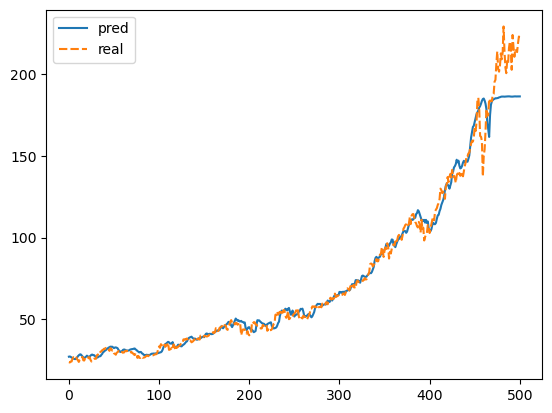

In [47]:
import seaborn as sns
df2 = pd.DataFrame({'pred': y_pred2,
                   'real': list(Y)})

sns.lineplot(data=df2[['pred','real']])

In [12]:
ticker_symbol = "MSFT"  # Google ticker symbol
start_date = "2010-11-01"
end_date = "2020-12-31"

# Fetch historical stock data
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date, interval="1wk")
stock = list(stock_data['Close'])
df = pd.DataFrame(columns=range(0,31))
for i in range(len(stock) - 30):
    row_data = stock[i:i+31]  # Extract i to i+5 elements
    df.loc[i] = row_data

[*********************100%%**********************]  1 of 1 completed


In [13]:
X = df.iloc[:,:-1]
Y = df.iloc[:,-1]

X2 = X.iloc[:,23:-4]
X2 = scale2.transform(X2)
y_pred = model2.predict(X2)

16/16 [==============================] - 0s 5ms/step


In [14]:
y_pred2=[]
for l in y_pred:
    for i in l:
        y_pred2.append(i)

<AxesSubplot: >

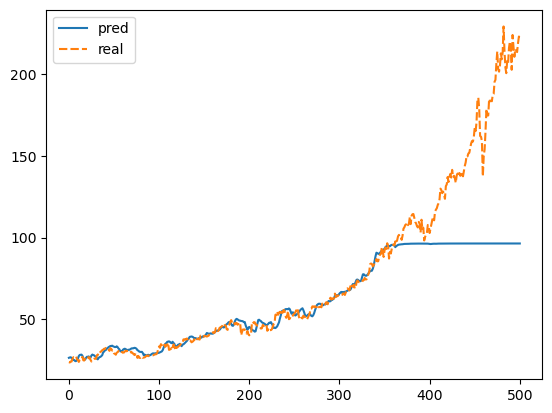

In [15]:
import seaborn as sns
df2 = pd.DataFrame({'pred': y_pred2,
                   'real': list(Y)})

sns.lineplot(data=df2[['pred','real']])